# returns

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit
import numba; numba.config.THREADING_LAYER = 'workqueue'
import empyrical

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/empyrical/utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)


In [1]:
import vectorbt as vbt

In [3]:
# Disable caching for performance testing
vbt.settings.caching['enabled'] = False
vbt.settings.returns['year_freq'] = '252 days' # same as empyrical

In [4]:
index = pd.DatetimeIndex([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
], freq='D')
columns = ['a', 'b', 'c']
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, 5], 
    'b': [5, 4, 3, 2, 1],
    'c': [1, 2, 3, 2, 1]
}, index=index).astype(np.float32)

print(ts)

              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0


In [5]:
big_ts = pd.DataFrame(np.random.randint(1, 10, size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

In [6]:
returns = ts.vbt.to_returns()
print(returns)

big_returns = big_ts.vbt.to_returns()

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.000000 -0.200000  1.000000
2018-01-03  0.500000 -0.250000  0.500000
2018-01-04  0.333333 -0.333333 -0.333333
2018-01-05  0.250000 -0.500000 -0.500000


In [7]:
np.random.seed(42)
benchmark_rets = returns['a'] * np.random.uniform(0.8, 1.2, returns.shape[0])
big_benchmark_rets = big_returns[0] * np.random.uniform(0.8, 1.2, big_returns.shape[0])

In [8]:
# Test year frequency
print(returns.vbt.returns.year_freq)
print(returns['a'].vbt.returns.year_freq)
print(returns.vbt.returns(year_freq='252 days').year_freq)
print(returns['a'].vbt.returns(year_freq='252 days').year_freq)

252 days 00:00:00
252 days 00:00:00
252 days 00:00:00
252 days 00:00:00


In [9]:
print(returns.vbt.returns.ann_factor) # default
print(returns.vbt.returns(year_freq='252 days').ann_factor)

252.0
252.0


In [10]:
print(returns['a'].vbt.returns.daily()) # already daily, do nothing
print(returns.vbt.returns.daily())

%timeit big_returns.vbt.returns.daily(parallel=False)
%timeit big_returns.vbt.returns.daily(parallel=True)

2018-01-01         NaN
2018-01-02    1.000000
2018-01-03    0.500000
2018-01-04    0.333333
2018-01-05    0.250000
Freq: D, Name: a, dtype: float64
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.000000 -0.200000  1.000000
2018-01-03  0.500000 -0.250000  0.500000
2018-01-04  0.333333 -0.333333 -0.333333
2018-01-05  0.250000 -0.500000 -0.500000
2.41 ms ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.46 ms ± 4.34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
print(returns['a'].vbt.returns.annual())
print(returns.vbt.returns.annual())

%timeit big_returns.vbt.returns.annual(parallel=False)
%timeit big_returns.vbt.returns.annual(parallel=True)

2018-01-01    4.0
Freq: 252D, Name: a, dtype: float64
              a    b    c
2018-01-01  4.0 -0.8  0.0
15.4 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
print(empyrical.cum_returns(returns['a']))
%timeit empyrical.cum_returns(big_returns[0])

print(returns['a'].vbt.returns.cumulative())
%timeit big_returns[0].vbt.returns.cumulative()

print(returns.vbt.returns.cumulative())
print(returns.vbt.returns.cumulative(start_value=1))
%timeit big_returns.vbt.returns.cumulative(parallel=False)
%timeit big_returns.vbt.returns.cumulative(parallel=True)

2018-01-01    0.0
2018-01-02    1.0
2018-01-03    2.0
2018-01-04    3.0
2018-01-05    4.0
Freq: D, dtype: float64
882 µs ± 8.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2018-01-01    0.0
2018-01-02    1.0
2018-01-03    2.0
2018-01-04    3.0
2018-01-05    4.0
Freq: D, Name: a, dtype: float64
2.62 ms ± 20.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  0.0  0.0  0.0
2018-01-02  1.0 -0.2  1.0
2018-01-03  2.0 -0.4  2.0
2018-01-04  3.0 -0.6  1.0
2018-01-05  4.0 -0.8  0.0
              a    b    c
2018-01-01  1.0  1.0  1.0
2018-01-02  2.0  0.8  2.0
2018-01-03  3.0  0.6  3.0
2018-01-04  4.0  0.4  2.0
2018-01-05  5.0  0.2  1.0
7.1 ms ± 68.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.66 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
print(empyrical.cum_returns_final(returns['a']))
%timeit empyrical.cum_returns_final(big_returns[0])

print(returns['a'].vbt.returns.total())
%timeit big_returns[0].vbt.returns.total()

print(returns.vbt.returns.total())
%timeit big_returns.vbt.returns.total(parallel=False)
%timeit big_returns.vbt.returns.total(parallel=True)

print(returns.vbt.returns.rolling_total(3, minp=1))
%timeit big_returns.vbt.returns.rolling_total(10, minp=1, parallel=False)
%timeit big_returns.vbt.returns.rolling_total(10, minp=1, parallel=True)

4.0
60.4 µs ± 369 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
4.0
2.66 ms ± 6.85 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    4.0
b   -0.8
c    0.0
Name: total_return, dtype: float64
8.92 ms ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.3 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a     b    c
2018-01-01  NaN   NaN  NaN
2018-01-02  1.0 -0.20  1.0
2018-01-03  2.0 -0.40  2.0
2018-01-04  3.0 -0.60  1.0
2018-01-05  1.5 -0.75 -0.5
34.4 ms ± 97.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.5 ms ± 479 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
print(empyrical.annual_return(returns['a']))
%timeit empyrical.annual_return(big_returns[0])

print(returns['a'].vbt.returns.annualized())
%timeit big_returns[0].vbt.returns.annualized()

print(returns.vbt.returns.annualized())
%timeit big_returns.vbt.returns.annualized(parallel=False)
%timeit big_returns.vbt.returns.annualized(parallel=True)

print(returns.vbt.returns.rolling_annualized(3, minp=1))
%timeit big_returns.vbt.returns.rolling_annualized(10, minp=1, parallel=False)
%timeit big_returns.vbt.returns.rolling_annualized(10, minp=1, parallel=True)

1.6907843469446035e+35
62.4 µs ± 671 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.0842021724855045e+44
2.69 ms ± 3.56 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    1.084202e+44
b   -1.000000e+00
c    0.000000e+00
Name: annualized_return, dtype: float64
7.76 ms ± 8.31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.14 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                       a    b             c
2018-01-01           NaN  NaN           NaN
2018-01-02  7.237006e+75 -1.0  7.237006e+75
2018-01-03  1.310021e+60 -1.0  1.310021e+60
2018-01-04  3.741444e+50 -1.0  1.934281e+25
2018-01-05  2.672765e+33 -1.0 -1.000000e+00
65.9 ms ± 291 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.7 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
print(empyrical.annual_volatility(returns['a'], alpha=3.))
%timeit empyrical.annual_volatility(big_returns[0], alpha=3.)

print(returns['a'].vbt.returns.annualized_volatility(levy_alpha=3.))
%timeit big_returns[0].vbt.returns.annualized_volatility(levy_alpha=3.)

print(returns.vbt.returns.annualized_volatility(levy_alpha=3.))
%timeit big_returns.vbt.returns.annualized_volatility(levy_alpha=3., parallel=False)
%timeit big_returns.vbt.returns.annualized_volatility(levy_alpha=3., parallel=True)

print(returns.vbt.returns.rolling_annualized_volatility(3, minp=1, levy_alpha=3.))
%timeit big_returns.vbt.returns.rolling_annualized_volatility(10, minp=1, levy_alpha=3., parallel=False)
%timeit big_returns.vbt.returns.rolling_annualized_volatility(10, minp=1, levy_alpha=3., parallel=True)

2.12183829613521
11.9 µs ± 98.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.12183829613521
2.71 ms ± 8.06 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    2.121838
b    0.830587
c    4.466341
Name: annualized_volatility, dtype: float64
7.89 ms ± 68.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.02 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02       NaN       NaN       NaN
2018-01-03  2.233170  0.223317  2.233170
2018-01-04  2.191425  0.425454  4.254544
2018-01-05  0.804033  0.804033  3.384043
43.5 ms ± 367 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
11.8 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
print(empyrical.calmar_ratio(returns['b']))
%timeit empyrical.calmar_ratio(big_returns[0])

print(returns['b'].vbt.returns.calmar_ratio())
%timeit big_returns[0].vbt.returns.calmar_ratio()

print(returns.vbt.returns.calmar_ratio())
%timeit big_returns.vbt.returns.calmar_ratio(parallel=False)
%timeit big_returns.vbt.returns.calmar_ratio(parallel=True)

print(returns.vbt.returns.rolling_calmar_ratio(3, minp=1))
%timeit big_returns.vbt.returns.rolling_calmar_ratio(10, minp=1, parallel=False)
%timeit big_returns.vbt.returns.rolling_calmar_ratio(10, minp=1, parallel=True)

-1.25
109 µs ± 316 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
-1.25
2.7 ms ± 6.15 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a     NaN
b   -1.25
c    0.00
Name: calmar_ratio, dtype: float64
15.1 ms ± 70.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.33 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
             a         b             c
2018-01-01 NaN       NaN           NaN
2018-01-02 NaN -5.000000           NaN
2018-01-03 NaN -2.500000           NaN
2018-01-04 NaN -1.666667  5.802844e+25
2018-01-05 NaN -1.333333 -1.500000e+00
167 ms ± 910 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
35.3 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
print(empyrical.omega_ratio(returns['c'], risk_free=0.01, required_return=0.1))
%timeit empyrical.omega_ratio(big_returns[0], risk_free=0.01, required_return=0.1)

print(returns['c'].vbt.returns.omega_ratio(risk_free=0.01, required_return=0.1))
%timeit big_returns[0].vbt.returns.omega_ratio(risk_free=0.01, required_return=0.1)

print(returns.vbt.returns.omega_ratio(risk_free=0.01, required_return=0.1))
%timeit big_returns.vbt.returns.omega_ratio(risk_free=0.01, required_return=0.1, parallel=False)
%timeit big_returns.vbt.returns.omega_ratio(risk_free=0.01, required_return=0.1, parallel=True)

print(returns.vbt.returns.rolling_omega_ratio(3, minp=1, risk_free=0.01, required_return=0.1))
%timeit big_returns.vbt.returns.rolling_omega_ratio(10, minp=1, risk_free=0.01, required_return=0.1, parallel=False)
%timeit big_returns.vbt.returns.rolling_omega_ratio(10, minp=1, risk_free=0.01, required_return=0.1, parallel=True)

1.7319528258777739
384 µs ± 295 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.7319528258777739
2.7 ms ± 5.76 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a         inf
b    0.000000
c    1.731953
Name: omega_ratio, dtype: float64
7.81 ms ± 24.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.75 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b         c
2018-01-01  NaN  NaN       NaN
2018-01-02  inf  0.0       inf
2018-01-03  inf  0.0       inf
2018-01-04  inf  0.0  4.303734
2018-01-05  inf  0.0  0.573267
28.4 ms ± 715 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
11.2 ms ± 837 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
print(empyrical.sharpe_ratio(returns['a'], risk_free=0.01))
%timeit empyrical.sharpe_ratio(big_returns[0], risk_free=0.01)

print(returns['a'].vbt.returns.sharpe_ratio(risk_free=0.01))
%timeit big_returns[0].vbt.returns.sharpe_ratio(risk_free=0.01)

print(returns.vbt.returns.sharpe_ratio(risk_free=0.01))
%timeit big_returns.vbt.returns.sharpe_ratio(risk_free=0.01, parallel=False)
%timeit big_returns.vbt.returns.sharpe_ratio(risk_free=0.01, parallel=True)

print(returns.vbt.returns.rolling_sharpe_ratio(3, minp=1, risk_free=0.01))
%timeit big_returns.vbt.returns.rolling_sharpe_ratio(10, minp=1, risk_free=0.01, parallel=False)
%timeit big_returns.vbt.returns.rolling_sharpe_ratio(10, minp=1, risk_free=0.01, parallel=True)

24.139821935485003
58.3 µs ± 234 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
24.139821935485003
2.71 ms ± 3.53 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    24.139822
b   -39.938441
c     3.517158
Name: sharpe_ratio, dtype: float64
10.4 ms ± 7.83 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.05 ms ± 80 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                    a           b          c
2018-01-01        NaN         NaN        NaN
2018-01-02        NaN         NaN        NaN
2018-01-03  33.225918 -105.514738  33.225918
2018-01-04  27.503960  -63.894198   8.929476
2018-01-05  43.786244  -46.280398  -3.588519
65.2 ms ± 649 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.9 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
print(returns.vbt.returns.deflated_sharpe_ratio(risk_free=0.01))
%timeit big_returns.vbt.returns.deflated_sharpe_ratio(risk_free=0.01)

# can specify var_sharpe and nb_trials expclicitly
print(big_returns[0].vbt.returns.deflated_sharpe_ratio(
    risk_free=0.01, 
    var_sharpe=np.var(big_returns.vbt.returns.sharpe_ratio(risk_free=0.01)),
    nb_trials=big_returns.shape[1]
))

a         NaN
b         NaN
c    0.000536
Name: deflated_sharpe_ratio, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/returns/metrics.py:26: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1 - skew * est_sharpe + ((kurtosis - 1) / 4) * est_sharpe ** 2))


20.5 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.0


In [20]:
print(empyrical.downside_risk(returns['b'], required_return=0.1))
%timeit empyrical.downside_risk(big_returns[0], required_return=0.1)

print(returns['b'].vbt.returns.downside_risk(required_return=0.1))
%timeit big_returns[0].vbt.returns.downside_risk(required_return=0.1)

print(returns.vbt.returns.downside_risk(required_return=0.1))
%timeit big_returns.vbt.returns.downside_risk(required_return=0.1, parallel=False)
%timeit big_returns.vbt.returns.downside_risk(required_return=0.1, parallel=True)

print(returns.vbt.returns.rolling_downside_risk(3, minp=1, required_return=0.1))
%timeit big_returns.vbt.returns.rolling_downside_risk(10, minp=1, required_return=0.1, parallel=False)
%timeit big_returns.vbt.returns.rolling_downside_risk(10, minp=1, required_return=0.1, parallel=True)

6.920801976649817
29.8 µs ± 56.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.920801976649817
2.7 ms ± 11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    0.000000
b    6.920802
c    5.874521
Name: downside_risk, dtype: float64
6.99 ms ± 6.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.15 ms ± 9.64 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a         b         c
2018-01-01  NaN       NaN       NaN
2018-01-02  0.0  4.762352  0.000000
2018-01-03  0.0  5.174456  0.000000
2018-01-04  0.0  5.798563  3.971566
2018-01-05  0.0  7.503555  6.783313
29.2 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.4 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
print(empyrical.sortino_ratio(returns['b'], required_return=0.1))
%timeit empyrical.sortino_ratio(big_returns[0], required_return=0.1)

print(returns['b'].vbt.returns.sortino_ratio(required_return=0.1))
%timeit big_returns[0].vbt.returns.sortino_ratio(required_return=0.1)

print(returns.vbt.returns.sortino_ratio(required_return=0.1))
%timeit big_returns.vbt.returns.sortino_ratio(required_return=0.1, parallel=False)
%timeit big_returns.vbt.returns.sortino_ratio(required_return=0.1, parallel=True)

print(returns.vbt.returns.rolling_sortino_ratio(3, minp=1, required_return=0.1))
%timeit big_returns.vbt.returns.rolling_sortino_ratio(10, minp=1, required_return=0.1, parallel=False)
%timeit big_returns.vbt.returns.rolling_sortino_ratio(10, minp=1, required_return=0.1, parallel=True)

-15.32336864395246
83.1 µs ± 516 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
-15.32336864395246
2.71 ms ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a          inf
b   -15.323369
c     2.859808
Name: sortino_ratio, dtype: float64
9.02 ms ± 12.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.78 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a          b          c
2018-01-01  NaN        NaN        NaN
2018-01-02  inf -15.874508        inf
2018-01-03  inf -15.827749        inf
2018-01-04  inf -15.693543  18.330303
2018-01-05  inf -15.485994  -7.842776
46.6 ms ± 528 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.2 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
print(empyrical.excess_sharpe(returns['a'], benchmark_rets))
%timeit empyrical.excess_sharpe(big_returns[0], benchmark_rets)

print(returns['a'].vbt.returns.information_ratio(benchmark_rets)) # will broadcast
%timeit big_returns[0].vbt.returns.information_ratio(big_benchmark_rets)

print(returns.vbt.returns.information_ratio(benchmark_rets))
%timeit big_returns.vbt.returns.information_ratio(big_benchmark_rets, parallel=False)
%timeit big_returns.vbt.returns.information_ratio(big_benchmark_rets, parallel=True)

print(returns.vbt.returns.rolling_information_ratio(benchmark_rets, 3, minp=1))
%timeit big_returns.vbt.returns.rolling_information_ratio(big_benchmark_rets, 10, minp=1, parallel=False)
%timeit big_returns.vbt.returns.rolling_information_ratio(big_benchmark_rets, 10, minp=1, parallel=True)

-0.5575108215121097
238 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
-0.5575108215121097
2.79 ms ± 3.91 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   -0.557511
b   -2.718676
c   -1.185416
Name: information_ratio, dtype: float64
10.8 ms ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.49 ms ± 40.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a          b         c
2018-01-01       NaN        NaN       NaN
2018-01-02       NaN        NaN       NaN
2018-01-03 -1.197205  -2.636038 -1.197205
2018-01-04 -0.903634  -2.536990 -0.905136
2018-01-05 -0.206482 -12.233912 -1.276646
63.6 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.9 ms ± 94.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
print(empyrical.beta(returns['a'], benchmark_rets))
%timeit empyrical.beta(big_returns[0], benchmark_rets)

print(returns['a'].vbt.returns.beta(benchmark_rets))
%timeit big_returns[0].vbt.returns.beta(big_benchmark_rets)

print(returns.vbt.returns.beta(benchmark_rets))
%timeit big_returns.vbt.returns.beta(big_benchmark_rets, parallel=False)
%timeit big_returns.vbt.returns.beta(big_benchmark_rets, parallel=True)

print(returns.vbt.returns.rolling_beta(benchmark_rets, 3, minp=1))
%timeit big_returns.vbt.returns.rolling_beta(big_benchmark_rets, 10, minp=1, parallel=False)
%timeit big_returns.vbt.returns.rolling_beta(big_benchmark_rets, 10, minp=1, parallel=True)

0.7853755858374825
733 µs ± 3.46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
0.7853755858374827
2.8 ms ± 7.39 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    0.785376
b    0.252235
c    1.547239
Name: beta, dtype: float64
14.3 ms ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.6 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02       NaN       NaN       NaN
2018-01-03       NaN       NaN       NaN
2018-01-04       NaN       NaN       NaN
2018-01-05  0.785376  0.252235  1.547239
29.4 ms ± 227 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.61 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
print(empyrical.alpha(returns['a'], benchmark_rets, risk_free=0.01))
%timeit empyrical.alpha(big_returns[0], benchmark_rets, risk_free=0.01)

print(returns['a'].vbt.returns.alpha(benchmark_rets, risk_free=0.01))
%timeit big_returns[0].vbt.returns.alpha(big_benchmark_rets, risk_free=0.01)

print(returns.vbt.returns.alpha(benchmark_rets, risk_free=0.01))
%timeit big_returns.vbt.returns.alpha(big_benchmark_rets, risk_free=0.01, parallel=True)
%timeit big_returns.vbt.returns.alpha(big_benchmark_rets, risk_free=0.01, parallel=True)

print(returns.vbt.returns.rolling_alpha(benchmark_rets, 3, minp=1, risk_free=0.01))
%timeit big_returns.vbt.returns.rolling_alpha(big_benchmark_rets, 10, minp=1, risk_free=0.01, parallel=True)
%timeit big_returns.vbt.returns.rolling_alpha(big_benchmark_rets, 10, minp=1, risk_free=0.01, parallel=True)

21533588.23721922
948 µs ± 3.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
21533588.23721922
2.83 ms ± 3.43 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    2.153359e+07
b   -1.000000e+00
c   -1.000000e+00
Name: alpha, dtype: float64
8.74 ms ± 92.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.77 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                       a    b             c
2018-01-01           NaN  NaN           NaN
2018-01-02           NaN  NaN           NaN
2018-01-03  1.221461e+07 -1.0  1.221461e+07
2018-01-04  1.606598e+06 -1.0 -1.000000e+00
2018-01-05  1.344192e+08 -1.0 -1.000000e+00
44.5 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
45.7 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
print(empyrical.tail_ratio(returns['a']))
%timeit empyrical.tail_ratio(big_returns[0])

print(returns['a'].vbt.returns.tail_ratio())
%timeit big_returns[0].vbt.returns.tail_ratio()

print(returns.vbt.returns.tail_ratio())
%timeit big_returns.vbt.returns.tail_ratio(parallel=False)
%timeit big_returns.vbt.returns.tail_ratio(parallel=True)

print(returns.vbt.returns.rolling_tail_ratio(3, minp=1))
%timeit big_returns.vbt.returns.rolling_tail_ratio(10, minp=1, parallel=False)
%timeit big_returns.vbt.returns.rolling_tail_ratio(10, minp=1, parallel=True)

%timeit big_returns.vbt.returns.rolling_tail_ratio(100, minp=1, parallel=False)
%timeit big_returns.vbt.returns.rolling_tail_ratio(100, minp=1, parallel=True)

3.523809523809523
125 µs ± 513 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
3.523809523809523
2.68 ms ± 7.51 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    3.523810
b    0.436842
c    1.947368
Name: tail_ratio, dtype: float64
24.4 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.53 ms ± 255 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.000000  1.000000  1.000000
2018-01-03  1.857143  0.818182  1.857143
2018-01-04  2.714286  0.630769  3.800000
2018-01-05  1.870968  0.534483  0.862069
132 ms ± 84.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
31.8 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.4 s ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
260 ms ± 6.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
print(empyrical.value_at_risk(returns.iloc[1:]['a'], cutoff=0.05))
%timeit empyrical.value_at_risk(big_returns[0], cutoff=0.05)

print(returns['a'].vbt.returns.value_at_risk(cutoff=0.05))
%timeit big_returns[0].vbt.returns.value_at_risk(cutoff=0.05)

print(returns.vbt.returns.value_at_risk(cutoff=0.05))
%timeit big_returns.vbt.returns.value_at_risk(cutoff=0.05, parallel=False)
%timeit big_returns.vbt.returns.value_at_risk(cutoff=0.05, parallel=True)

print(returns.vbt.returns.rolling_value_at_risk(3, minp=1, cutoff=0.05))
%timeit big_returns.vbt.returns.rolling_value_at_risk(10, minp=1, cutoff=0.05, parallel=False)
%timeit big_returns.vbt.returns.rolling_value_at_risk(10, minp=1, cutoff=0.05, parallel=True)

0.2625
63.7 µs ± 336 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
0.2625
2.72 ms ± 38.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    0.2625
b   -0.4750
c   -0.4750
Name: value_at_risk, dtype: float64
15 ms ± 935 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.59 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.000000 -0.200000  1.000000
2018-01-03  0.525000 -0.247500  0.525000
2018-01-04  0.350000 -0.325000 -0.250000
2018-01-05  0.258333 -0.483333 -0.483333
78.8 ms ± 717 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
19.2 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
print(empyrical.conditional_value_at_risk(returns.iloc[1:]['a'], cutoff=0.05))
%timeit empyrical.conditional_value_at_risk(big_returns[0], cutoff=0.05)

print(returns['a'].vbt.returns.cond_value_at_risk(cutoff=0.05))
%timeit big_returns[0].vbt.returns.cond_value_at_risk(cutoff=0.05)

print(returns.vbt.returns.cond_value_at_risk(cutoff=0.05))
%timeit big_returns.vbt.returns.cond_value_at_risk(cutoff=0.05, parallel=False)
%timeit big_returns.vbt.returns.cond_value_at_risk(cutoff=0.05, parallel=True)

print(returns.vbt.returns.rolling_cond_value_at_risk(3, minp=1, cutoff=0.05))
%timeit big_returns.vbt.returns.rolling_cond_value_at_risk(10, minp=1, cutoff=0.05, parallel=False)
%timeit big_returns.vbt.returns.rolling_cond_value_at_risk(10, minp=1, cutoff=0.05, parallel=True)

0.25
19.8 µs ± 162 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
0.25
2.67 ms ± 11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    0.25
b   -0.50
c   -0.50
Name: cond_value_at_risk, dtype: float64
14.8 ms ± 20.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.99 ms ± 86.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.000000 -0.200000  1.000000
2018-01-03  0.500000 -0.250000  0.500000
2018-01-04  0.333333 -0.333333 -0.333333
2018-01-05  0.250000 -0.500000 -0.500000
38.7 ms ± 3.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.7 ms ± 246 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
print(empyrical.capture(returns['a'], benchmark_rets))
%timeit empyrical.capture(big_returns[0], big_benchmark_rets)

print(returns['a'].vbt.returns.capture(benchmark_rets))
%timeit big_returns[0].vbt.returns.capture(big_benchmark_rets)

print(returns.vbt.returns.capture(benchmark_rets))
%timeit big_returns.vbt.returns.capture(big_benchmark_rets, parallel=False)
%timeit big_returns.vbt.returns.capture(big_benchmark_rets, parallel=True)

print(returns.vbt.returns.rolling_capture(benchmark_rets, 3, minp=1))
%timeit big_returns.vbt.returns.rolling_capture(big_benchmark_rets, 10, minp=1, parallel=False)
%timeit big_returns.vbt.returns.rolling_capture(big_benchmark_rets, 10, minp=1, parallel=True)

0.0069170702789772874
120 µs ± 571 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
0.0019948155055032196
2.82 ms ± 7.87 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    1.994816e-03
b   -1.839893e-47
c    0.000000e+00
Name: capture, dtype: float64
13.4 ms ± 12 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.41 ms ± 408 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                       a             b             c
2018-01-01           NaN           NaN           NaN
2018-01-02  3.582444e-10 -4.950174e-86  3.582444e-10
2018-01-03  4.074546e-07 -3.110292e-67  4.074546e-07
2018-01-04  2.409369e-05 -6.439675e-56  1.245614e-30
2018-01-05  3.535715e-01 -1.322868e-34 -1.322868e-34
127 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
28.8 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
print(empyrical.up_capture(returns['a'], benchmark_rets))
%timeit empyrical.up_capture(big_returns[0], big_benchmark_rets)

print(returns['a'].vbt.returns.up_capture(benchmark_rets))
%timeit big_returns[0].vbt.returns.up_capture(big_benchmark_rets)

print(returns.vbt.returns.up_capture(benchmark_rets))
%timeit big_returns.vbt.returns.up_capture(big_benchmark_rets, parallel=False)
%timeit big_returns.vbt.returns.up_capture(big_benchmark_rets, parallel=True)

print(returns.vbt.returns.rolling_up_capture(benchmark_rets, 3, minp=1))
%timeit big_returns.vbt.returns.rolling_up_capture(big_benchmark_rets, 10, minp=1, parallel=False)
%timeit big_returns.vbt.returns.rolling_up_capture(big_benchmark_rets, 10, minp=1, parallel=True)

0.0019948155055032196
381 µs ± 2.43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
0.0019948155055032196
3.43 ms ± 735 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    1.994816e-03
b             NaN
c    2.410297e+13
Name: up_capture, dtype: float64
13 ms ± 339 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.79 ms ± 569 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                       a   b             c
2018-01-01           NaN NaN           NaN
2018-01-02  3.582444e-10 NaN  3.582444e-10
2018-01-03  4.074546e-07 NaN  4.074546e-07
2018-01-04  2.409369e-05 NaN  8.436107e+04
2018-01-05  3.535715e-01 NaN  3.136994e+10
156 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
33.8 ms ± 894 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
print(empyrical.down_capture(returns['a'], benchmark_rets))
%timeit empyrical.down_capture(big_returns[0], big_benchmark_rets)

print(returns['a'].vbt.returns.down_capture(benchmark_rets))
%timeit big_returns[0].vbt.returns.down_capture(big_benchmark_rets)

print(returns.vbt.returns.down_capture(benchmark_rets))
%timeit big_returns.vbt.returns.down_capture(big_benchmark_rets, parallel=False)
%timeit big_returns.vbt.returns.down_capture(big_benchmark_rets, parallel=True)

print(returns.vbt.returns.rolling_down_capture(benchmark_rets, 3, minp=1))
%timeit big_returns.vbt.returns.rolling_down_capture(big_benchmark_rets, 10, minp=1, parallel=False)
%timeit big_returns.vbt.returns.rolling_down_capture(big_benchmark_rets, 10, minp=1, parallel=True)

nan
373 µs ± 1.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
nan
2.82 ms ± 8.91 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   NaN
b   NaN
c   NaN
Name: down_capture, dtype: float64
13.1 ms ± 430 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.48 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
             a   b   c
2018-01-01 NaN NaN NaN
2018-01-02 NaN NaN NaN
2018-01-03 NaN NaN NaN
2018-01-04 NaN NaN NaN
2018-01-05 NaN NaN NaN
158 ms ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
36 ms ± 540 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
print(returns.vbt.returns.drawdown())

%timeit big_returns.vbt.returns.drawdown(parallel=False)
%timeit big_returns.vbt.returns.drawdown(parallel=True)

              a    b         c
2018-01-01  0.0  0.0  0.000000
2018-01-02  0.0 -0.2  0.000000
2018-01-03  0.0 -0.4  0.000000
2018-01-04  0.0 -0.6 -0.333333
2018-01-05  0.0 -0.8 -0.666667
11 ms ± 78.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.86 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
print(empyrical.max_drawdown(returns['b']))
%timeit empyrical.max_drawdown(big_returns[0])

print(returns['b'].vbt.returns.max_drawdown())
%timeit big_returns[0].vbt.returns.max_drawdown()

print(returns.vbt.returns.max_drawdown())
%timeit big_returns.vbt.returns.max_drawdown(parallel=False)
%timeit big_returns.vbt.returns.max_drawdown(parallel=True)

print(returns.vbt.returns.rolling_max_drawdown(3, minp=1))
%timeit big_returns.vbt.returns.rolling_max_drawdown(10, minp=1, parallel=False)
%timeit big_returns.vbt.returns.rolling_max_drawdown(10, minp=1, parallel=True)

-0.8
40 µs ± 440 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
-0.7999999999999999
2.72 ms ± 37.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    0.000000
b   -0.800000
c   -0.666667
Name: max_drawdown, dtype: float64
9.69 ms ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.6 ms ± 452 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a     b         c
2018-01-01  NaN   NaN       NaN
2018-01-02  0.0 -0.20  0.000000
2018-01-03  0.0 -0.40  0.000000
2018-01-04  0.0 -0.60 -0.333333
2018-01-05  0.0 -0.75 -0.666667
106 ms ± 424 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.5 ms ± 329 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
print(returns.vbt.returns.drawdowns)
%timeit big_returns.vbt.returns.drawdowns

print(returns.vbt.returns.drawdowns.max_drawdown())

Drawdowns(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7fb4a0a65ef0> of shape (5, 3)",
    "records_arr": "<numpy.ndarray object at 0x7fb4865b94e0> of shape (2,)",
    "idx_field": "end_idx",
    "col_mapper": null,
    "ts": "<pandas.core.frame.DataFrame object at 0x7fb486d7a438> of shape (5, 3)"
}))
11.3 ms ± 620 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
a         NaN
b   -0.800000
c   -0.666667
Name: max_drawdown, dtype: float64


In [42]:
print(returns['b'].vbt.returns.stats(
    settings=dict(benchmark_rets=benchmark_rets, levy_alpha=3., risk_free=0.01, required_return=0.1)))
%timeit big_returns[0].vbt.returns.stats(\
    silence_warnings=True,\
    settings=dict(benchmark_rets=big_benchmark_rets, levy_alpha=3., risk_free=0.01, required_return=0.1))

print(returns.vbt.returns.stats(
    settings=dict(benchmark_rets=benchmark_rets, levy_alpha=3., risk_free=0.01, required_return=0.1)))
%timeit big_returns.vbt.returns.stats(\
    silence_warnings=True,\
    settings=dict(benchmark_rets=big_benchmark_rets, levy_alpha=3., risk_free=0.01, required_return=0.1))

Start                        2018-01-01 00:00:00
End                          2018-01-05 00:00:00
Period                           5 days 00:00:00
Total Return [%]                      -79.999999
Benchmark Return [%]                   451.85973
Annualized Return [%]                     -100.0
Annualized Volatility [%]               83.05873
Max Drawdown [%]                       79.999999
Max Drawdown Duration            4 days 00:00:00
Sharpe Ratio                          -39.938439
Calmar Ratio                               -1.25
Omega Ratio                                  0.0
Sortino Ratio                         -15.323369
Skew                                   -1.065369
Kurtosis                                0.645216
Tail Ratio                              0.436842
Common Sense Ratio                           0.0
Value at Risk                             -0.475
Alpha                                       -1.0
Beta                                    0.252235
Name: b, dtype: obje

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Object has multiple columns. Aggregating using <function mean at 0x7fb48139f9d8>. Pass column to select a single column/group.
  


207 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


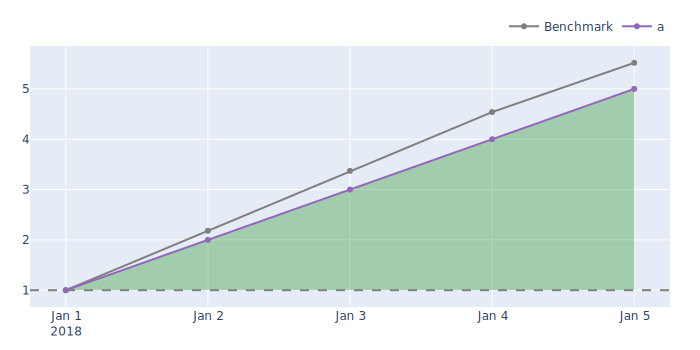

In [43]:
returns['a'].vbt.returns.plot_cumulative(benchmark_rets).show_svg()

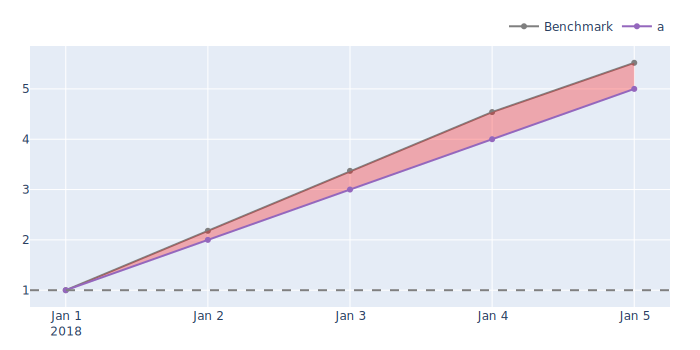

In [44]:
returns['a'].vbt.returns.plot_cumulative(benchmark_rets, fill_to_benchmark=True).show_svg()